<a href="https://colab.research.google.com/github/MarioROT/CV-MAI/blob/main/Session%202/image_operators_and_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory #02 : Image Operators and Filters

At the end of this laboratory, you would get familiarized with

*   Image Handling
*   Image Manipulation
*   Histogram and Histogram Equalization
*   Basic filtering techniques

### **Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Add sufficient comments and explanations wherever necessary.

---


In [1]:
%%shell
git clone https://github.com/MarioROT/CV-MAI
mv CV-MAI/scripts/custom_plots.py /content/
mv "CV-MAI/Session 2/images/" /content/
mv "CV-MAI/Session 2/notebook_images/" /content/

Cloning into 'CV-MAI'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 124 (delta 56), reused 57 (delta 16), pack-reused 0
Receiving objects: 100% (124/124), 12.88 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [2]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from matplotlib import pyplot as plt
from skimage import data, exposure, filters, io, morphology, color, transform
import custom_plots as cp

# Channels and color spaces

### **Exercise: Image Creation and Color Manipulation**

*   Create a 100 x 100 image for each of the below visualization

![black_and_white_patches.png](https://drive.google.com/uc?export=view&id=1Iuf870gS6DuFzMtnXs53DLuiXy0oARaw)

*   Visualize the created images in a 1 x 3 subplot using matplotlib.


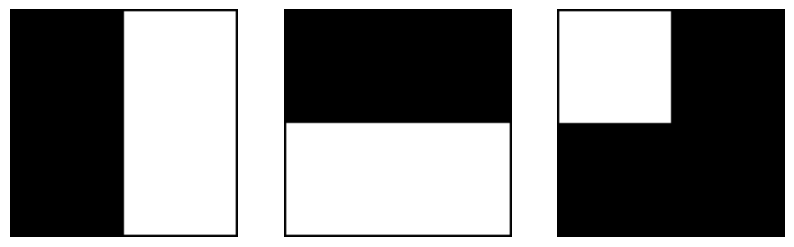

In [3]:
# solution

# First zeros (black) arrays are created, then specific colums
# are modified from 0 to 255 to have the desired white parts.

# Right half white
img1 = np.zeros([100,100],dtype=np.int32)
img1[1:99:1,50:99] = 255

# Lower half white
img2 = np.zeros([100,100],dtype=np.int32)
img2[50:99,1:99:1] = 255

# Upper left corner white
img3 = np.zeros([100,100],dtype=np.int32)
img3[1:50,1:50] = 255

# Using custom code based on matlplotlib to plot the 3 images
cp.custom_grids([img1,img2, img3],1,3, axis='off', cmap='gray', use_grid_spec=False).show()

*   Use the above three images to create the following image

![color_patches.png](https://drive.google.com/uc?export=view&id=1UxmFHToC4TUjgtB7UQMbB3DM3RIZlgBZ)

*Hint: Remember channels and color spaces*

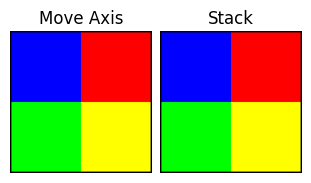

In [5]:
# solution
# All previous created images are combined in a single array
# we move the channels dim to the end for matplotlib to show the image
# (3,100,100) --> (100,100,3)
colors_img = np.moveaxis([img1, img2, img3], 0,-1).astype(np.uint8)

#other way to combine the channels
colors_img2 =np.stack((img1,img2,img3),axis=-1)

cp.custom_grids([colors_img,colors_img2],1,2, ['Move Axis', 'Stack'],figsize=(3,3), axis='off').show()


### **Exercise: Color Manipulation**

*   Read the image 'sillas.jpg' from the images folder

![sillas.jpg](https://drive.google.com/uc?export=view&id=1Ged9FdDWIcipbNxNatGgCZyRdQvcGtoG)

*   Extract individual channels and plot them using matplotlib subplot.



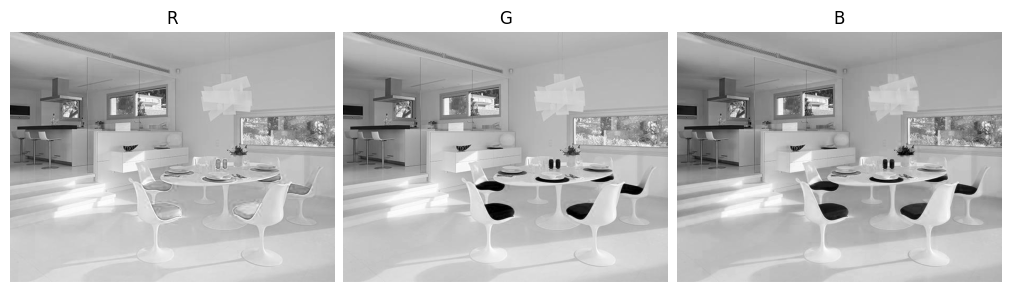

In [6]:
# solution
room_img = io.imread('notebook_images/sillas.jpg')
red, green, blue = room_img[:,:,0], room_img[:,:,1], room_img[:,:,2]
cp.custom_grids([red, green, blue], 1, 3, ['R', 'G', 'B'], axis='off', cmap='gray').show()

*   The color **red** looks too bright for the eyes. Isn't it?? Lets change the color and see how it appears.
    *    Create a new image where everything that is **'red' is changed to 'blue'**.
*   Visualize the original image and the created image using matplotlib subplot.

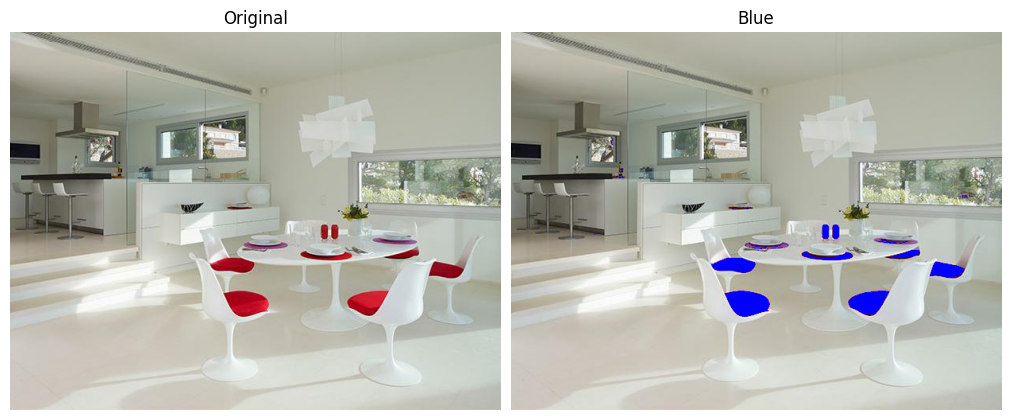

In [7]:
# solution
# Segmenting a red sample from the image and computing min value for red
# and max value for green and blue to get some tresholds of what values compose
# red things in the image. We add an adjustment to the values obtained in order
# to have a larger margin of reds.
red_sq = room_img[330:348, 439:465]
rmin = red_sq[:,:,0].min() - 35
gmax = red_sq[:,:,1].max() + 35
bmax = red_sq[:,:,2].max() + 35
room_img_blue=room_img.copy()

# Applying tresholds to a copy of the image to mute red and highlight blue on originally red zones.
room_img_blue[:,:,0] = np.where((red>rmin) & (green < gmax) & (blue < bmax), 0, red)
room_img_blue[:,:,1] = np.where((red>rmin) & (green < gmax) & (blue < bmax), 0, green)
room_img_blue[:,:,2] = np.where((red>rmin) & (green < gmax) & (blue < bmax), 255, blue)

cp.custom_grids([room_img,room_img_blue], 1, 2,['Original','Blue'], axis='off', figsize=(10,10)).show()

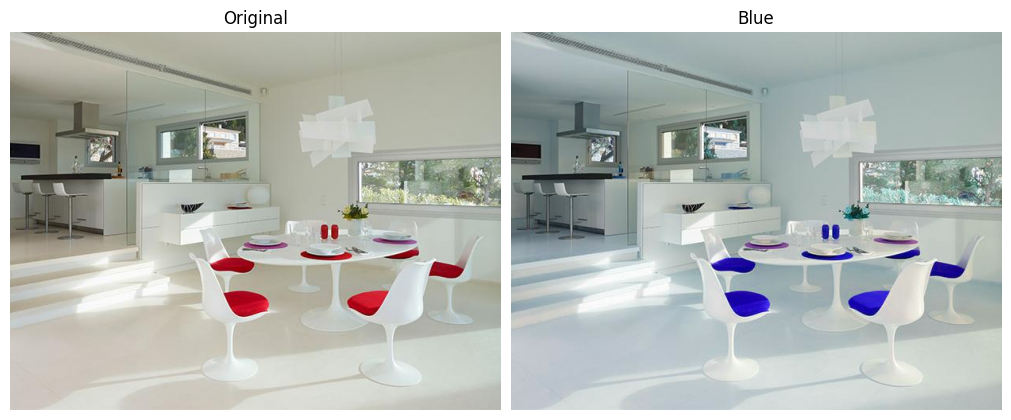

In [8]:
#Some other solution

#We can interchange the Red and Blue channels in order to change the colors
cp.custom_grids([room_img,np.stack((blue,green,red),axis=-1)],1,2,['Original','Blue'],axis='off').show()

# Image Manipulation

### **Exercise: Image Operators**

*   You can find images 'model.png' and 'coat.png' in the images folder (First two images of the below visualization). Your task is to create an image from the given two images such a way that the model is wearing the coat (Third image in the visualization).
*   You can also find different textures in the images folder. Your task is to change the coat texture to any one of the given textures.
*   Visualize the images similar to the given visualization.

*Hint: Think masks!!!*

![model_and_coat.png](https://drive.google.com/uc?export=view&id=1DOieJOrfwe34z0-3EEBVyX1Ac45sb5SN)


In [9]:
def prepare_img(img, channels, dims):
  if img.shape[-3] > channels: #Shouldn't it be img.shape[2] ?
    img = img[:,:,:3]
  if img.shape[:2] != dims:
    img = transform.resize(img, dims, preserve_range=True)
  return img.astype(int)

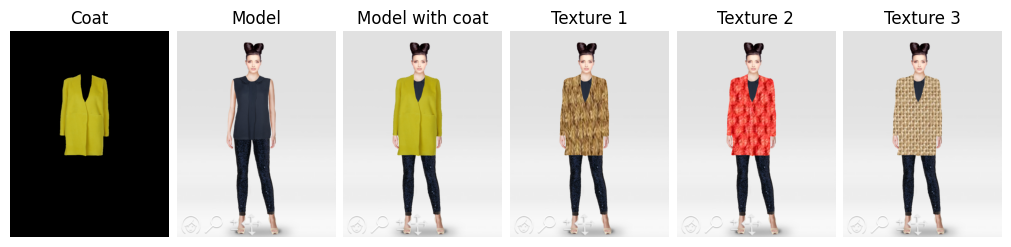

In [10]:
# solution

# Reading all images and preprocessing them to have the same number of channels and size
folder = '/content/images/'
model = io.imread(folder + 'model.png')
model = prepare_img(model, 3, model.shape[:2])
coat = prepare_img(io.imread(folder + 'coat.png'), 3, model.shape[:2])
textures = ['texture.png', 'texture2.png', 'texture3.jpg']

model_coat = np.where(coat != 0, coat, model)
model_t1 = np.where(coat != 0, prepare_img(io.imread(folder + textures[0]), 3, model.shape[:2]), model)
model_t2 = np.where(coat != 0, prepare_img(io.imread(folder + textures[1]), 3, model.shape[:2]), model)
model_t3 = np.where(coat != 0, prepare_img(io.imread(folder + textures[2]), 3, model.shape[:2]), model)

cp.custom_grids([coat, model, model_coat, model_t1, model_t2, model_t3], 1, 6, ['Coat', 'Model', 'Model with coat', 'Texture 1', 'Texture 2', 'Texture 3'], axis='off').show()


# Contrast Enhancement

### **Exercise: Histogram Computation**

*   Read the **'astronaut' image** from data module.
*   Convert the image to grayscale.
*   Compute the **histogram of the image.** *Hint: histogram function is available in skimage.exposure package*
*   Plot the histogram using matplotlib plot.




<BarContainer object of 256 artists>

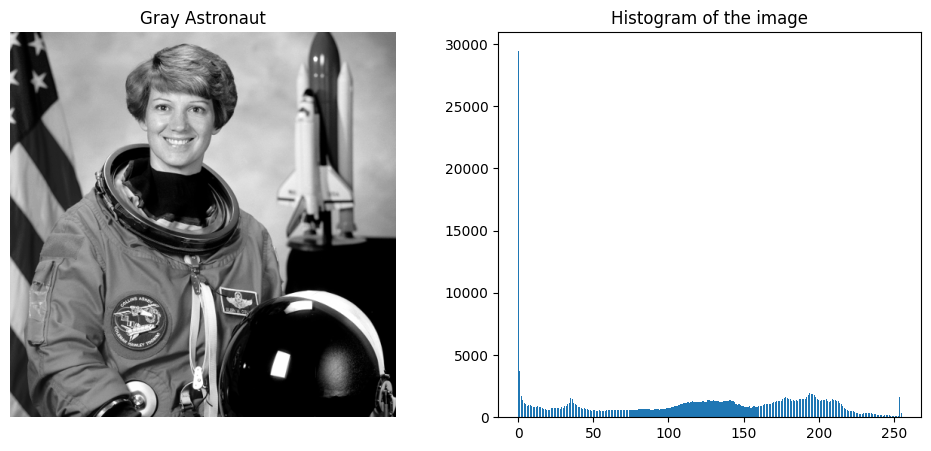

In [11]:
# solution

#Reading the astronaut image and convert to grayscale
astr = data.astronaut()
astr_gray= color.rgb2gray(astr)

#Checking the RGB to Gray modification
cust = cp.custom_grids([astr_gray],1,2, ['Gray Astronaut'], axis='off', cmap = 'gray', figsize=(12,5), use_grid_spec=False)
cust.show()

#Histogram of the image
values, centers = exposure.histogram(astr_gray)
cust.add_plot('Histogram of the image').bar(range(256), values)

*   Change the bin count to 8 and compute the histogram of the image and plot the computed histogram using matplotlib plot.

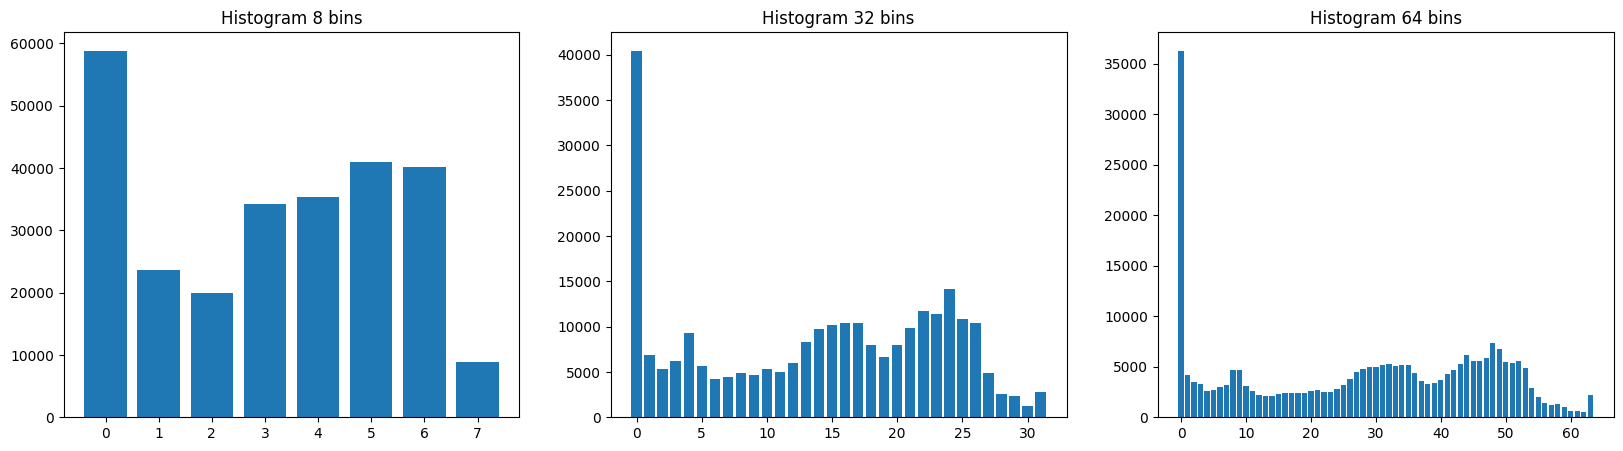

In [12]:
# solution
cust = cp.custom_grids([],1,3, figsize=(20,5), use_grid_spec=False)
cust.show()

for binsNum in [8,32,64]:
  values, centers = exposure.histogram(astr_gray, binsNum)
  cust.add_plot(f'Histogram {binsNum} bins').bar(range(binsNum), values)



*   What happens when you change the bin count? Does your inference change based on the bin count? If yes, then how do you define the correct bin count.
*   What happens when the bin count is very low and what happens when it is very high?



**Solution**

- When changing the bin count, the frequency of various values of pixels are added in the same group (bin) and therefore the values on the x axis are reduced while the values on the y axis are increased.

- When reducing the bins we can lose a bit of the details and the dispersion of the values of intensity, however the inference on the contrast of the image is still the same, since the skewness of the distribution is still present.

- With a very low count of bins we will not be able to properly interpret the results due to the large range of values in the same bin. On the onther hand, a large value of bins may have a problem of scale if the distribution is skewed with a large number of pixels in the same instensity values, and not showing the details of variation within the other bins.


*   Compute histogram of the color image (without converting it to grayscale).
*   Plot the total histogram and also histogram for each channel (show it in a single plot with differnt legends for each histogram).


<BarContainer object of 64 artists>

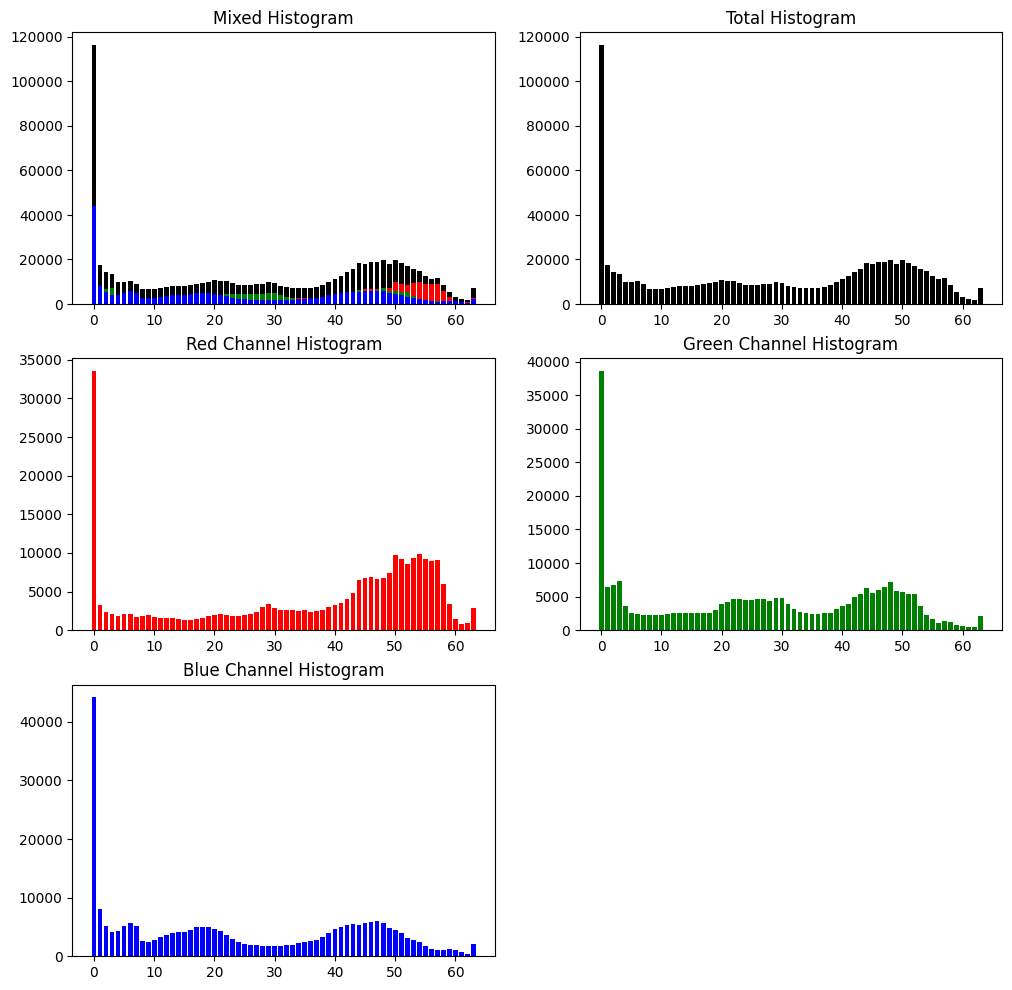

In [13]:
#solution
vals = exposure.histogram(astr.astype(float), nbins=64, channel_axis=2)[0]

cust = cp.custom_grids([], 3, 2, figsize=(12,12), axis='off', use_grid_spec=False)
cust.show()
f_plot = cust.add_plot(f'Mixed Histogram')
f_plot.bar(range(64),sum(vals), color = 'black')
f_plot.bar(range(64),vals[0], color = 'red')
f_plot.bar(range(64),vals[1], color = 'green')
f_plot.bar(range(64),vals[2], color = 'blue')

cust.add_plot('Total Histogram').bar(range(64), sum(vals), color='black')
cust.add_plot('Red Channel Histogram').bar(range(64),vals[0], color = 'red')
cust.add_plot('Green Channel Histogram').bar(range(64),vals[1], color = 'green')
cust.add_plot('Blue Channel Histogram', last=True).bar(range(64),vals[2], color = 'blue')


### **Exercise: Histogram Equalization**

*   Read 'aquatermi_lowcontrast.jpg' image from the images folder.
*   Compute the histogram of the image.
*   Perform histogram equalization of the image to enhance the contrast. *Hint: Use equalize_hist function available in skimage.exposure*
*   Also compute histogram of the equalized image.
*   Use 2 x 2 subplot to show the original image and the enhanced image along with the corresponding histograms.



/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


<BarContainer object of 256 artists>

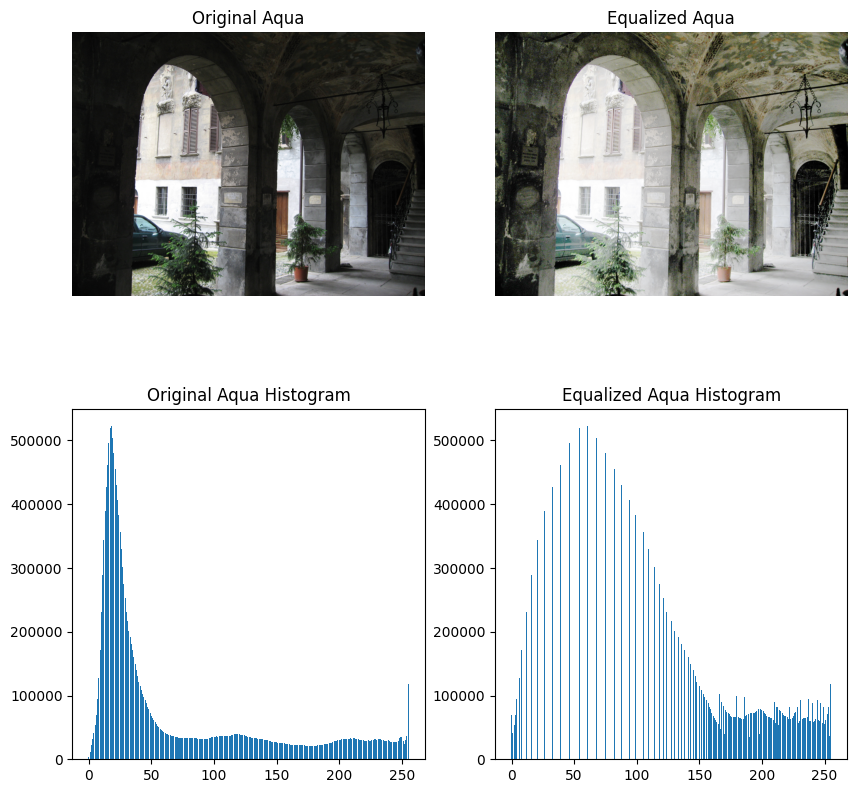

In [23]:
# solution
aqua=io.imread('/content/images/aquatermi_lowcontrast.jpg')

hist=exposure.histogram(aqua,channel_axis=2)[0]

aqua_eq=exposure.equalize_hist(aqua)
hist_eq=exposure.histogram(aqua_eq,channel_axis=2)[0]

cust = cp.custom_grids([aqua,aqua_eq], 2, 2,['Original Aqua','Equalized Aqua'], figsize=(10,10), axis='off', use_grid_spec=False)
cust.show()
cust.add_plot("Original Aqua Histogram").bar(range(256),sum(hist))
cust.add_plot("Equalized Aqua Histogram").bar(range(256),sum(hist_eq))


*   The above function in skimage.exposure uses cdf and interpolation technique to normalize the histogram. How is it different from linear contrast stretch?


**Solution**
- The main difference is that a linear contrast stretch consider a normal distibution that may be based on the min and max values, or the standard deviation, rescaling the actual values of intensity in a sort of "zoom in".

- Meanwhile, the histogram equalization changes the actual distribution by taking the high populated intensity values and distribute them evenly. As we can see in the Equalized aqua histogram, where we can find multiple gaps on the distribution.

### **Exercise: Linear Contrast Stretch**

*   Write a function to compute the linear contrast stretch (Do not use an inbuilt function).
*   Provide grayscale image array and bin count as parameters to the function and return the enhanced image array.
*   Use a 2 x 2 plot to visualize the original image, histogram, enhanced image and the corresponding histogram.



In [20]:
# solution
#Function to linear stretch and type of stretching selector: 1 for min-max, 2 for std dev
def lin_str (img,range,type,NBins):
    if type==1: #Min max linear stretch
      min=(img.min())
      max=(img.max())

      str_img=(img-min)/(max-min)*range
      hist_str=exposure.histogram(str_img,NBins)[0]

    if type==2: #Standard deviation linear stretch
      mean=(np.mean(img))
      std=(np.std(img))

      str_min=np.where(img<(mean-std),(mean-std),img)
      str_img=np.where(str_min>=(mean+std),(mean+std),str_min)
      hist_str=exposure.histogram(str_img,NBins)[0]

    return str_img.astype(int), hist_str.astype(int)

<BarContainer object of 64 artists>

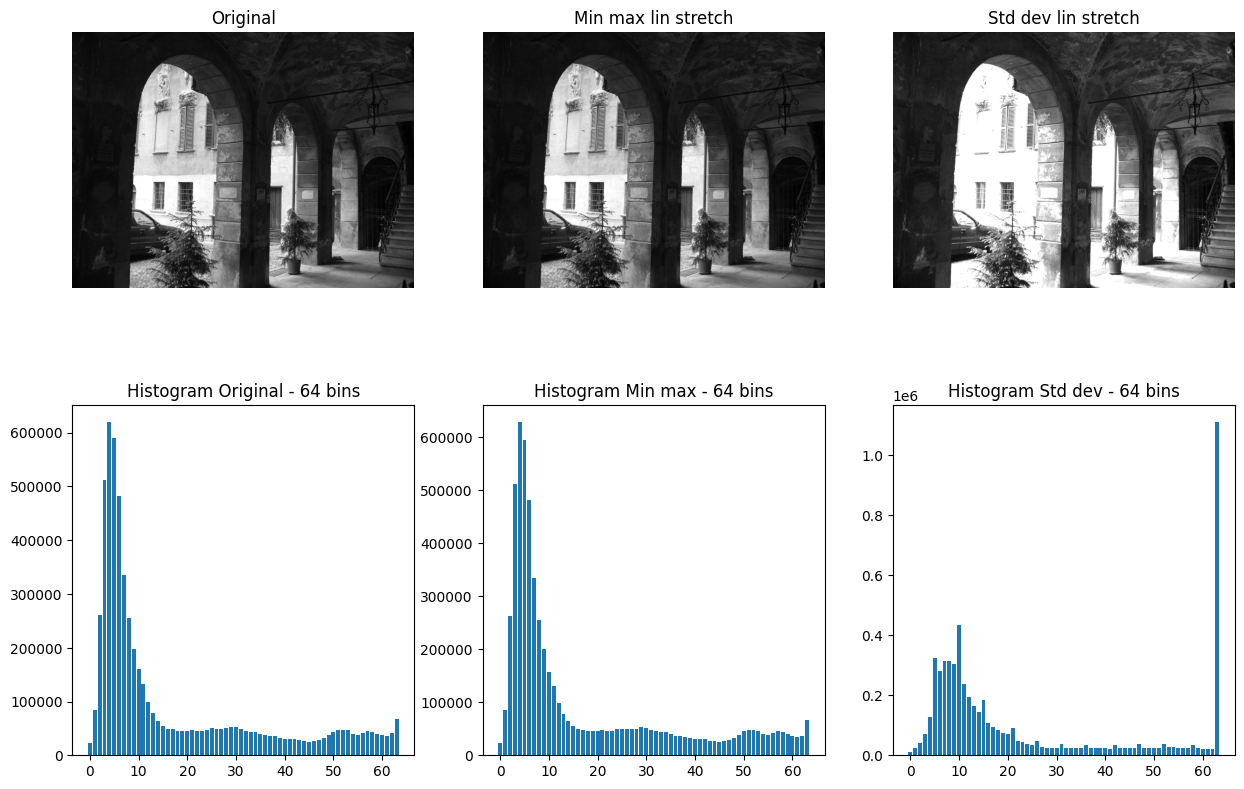

In [16]:
# 1)Since the grayscale outputs a range from 0 to 1, we added the gray image in the stretching function

bins=64 #Select the number of bins
aqua_gray=lin_str(color.rgb2gray(aqua),255,1,bins) #1)
aqua_str_min=lin_str(aqua_gray[0],255,1,bins)
aqua_str_mean=lin_str(aqua_gray[0],255,2,bins)

plot= cp.custom_grids([aqua_gray[0],aqua_str_min[0],aqua_str_mean[0]],2,3,['Original','Min max lin stretch','Std dev lin stretch'],figsize=(15,10),axis='off',cmap='gray',use_grid_spec=False)
plot.show()
plot.add_plot(f'Histogram Original - {bins} bins').bar(range(bins), aqua_gray[1])
plot.add_plot(f'Histogram Min max - {bins} bins').bar(range(bins), aqua_str_min[1])
plot.add_plot(f'Histogram Std dev - {bins} bins').bar(range(bins), aqua_str_mean[1])



# Filters

### **Exercise: Mean Filter**

*   Load the **coins** image from the data module.
*   Define a disk structuring element (selem) of radius 20. *Hint: Structuring elements are defined in the skimage.morphology module*
*   Use mean filter using the created selem. *Hint: The mean filter is available in skimage.filters.rank module*
*   Increase the radius of the selem by 10 and apply the mean filter.
*   Reduce the radius of the selem by 10 and apply the mean filter.
*   Visualize all the smoothened images along with the original image.




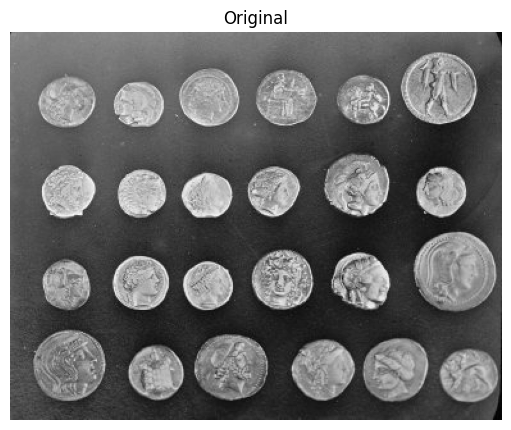

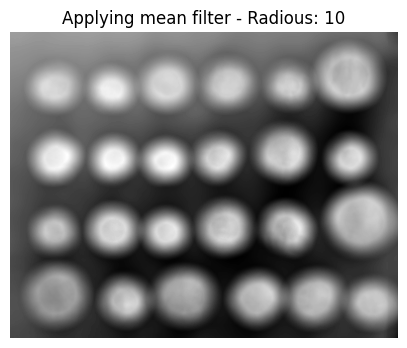

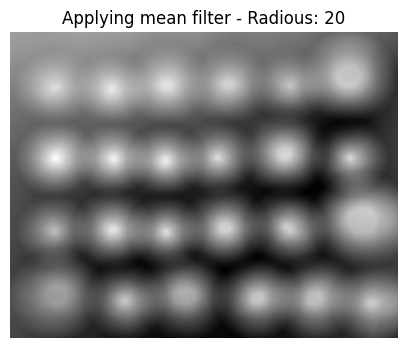

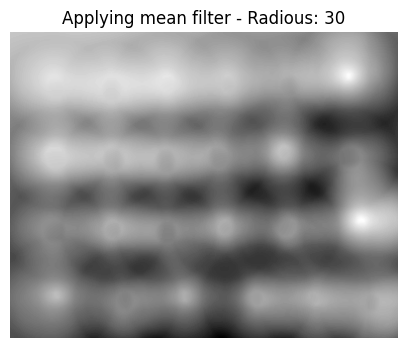

In [98]:
# solution
coins=data.coins()
cust=cp.custom_grids([coins],1,1,['Original'],figsize=(5,5),axis='off',cmap='gray').show()
mean_filter=[]

for selem in [10,20,30]:
  selems = morphology.disk(selem)
  mean_filter.append(filters.rank.mean(coins,selems))
  cp.custom_grids([(mean_filter[selem//10-1])],1,1,[f'Applying mean filter - Radious: {selem}'],figsize=(5,5),axis='off',cmap='gray',use_grid_spec=False).show()

*   Use different selem (square, rectangle, star, diamond) to view the behaviour of the mean filter (It is not necessary to repeat with different sizes; it is sufficient to show the one with optimal parameter).
*   Create a 2 x n subplot to show the selem in the first row and the corresponding smoothened image in the second row.

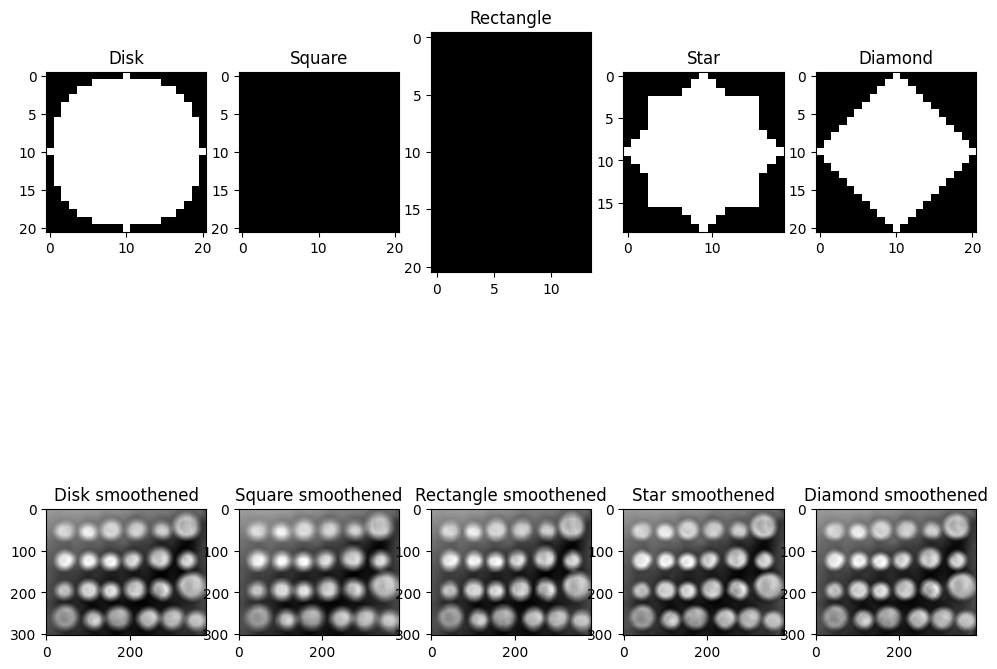

In [99]:
# solution

rad=10

disk=morphology.disk(rad)
square=morphology.square(rad*2+1)
rectangle=morphology.rectangle(rad*2+1,(rad*2+1)//3*2)
star=morphology.star(rad-4)
diamond=morphology.diamond(rad)

selem=[disk,square,rectangle,star,diamond]
filt=[]
for figures in selem:
  filt.append(filters.rank.mean(coins,figures))

cp.custom_grids([selem[0],selem[1],selem[2],selem[3],selem[4],filt[0],filt[1],filt[2],filt[3],filt[4]],2,5,['Disk','Square','Rectangle','Star','Diamond','Disk smoothened','Square smoothened','Rectangle smoothened','Star smoothened','Diamond smoothened'],cmap='gray',figsize=(12,10),use_grid_spec=False).show()


*   How does changing the radius of disk affect the smoothing functionality?

**Solution**

*(Double-click or enter to edit)*

...


*   What is the observed behaviour with difference in the structuring element?



**Solution**

*(Double-click or enter to edit)*

...



*   What is the difference between mean filter and gaussian filter?
*   Where do you use mean filters and where do you use gaussian filters?



**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P2: Image operators and filters**

Deadline for P2 submission in CampusVirtual is: **Thursday, the 6th of October, 2022**
